In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('/home/hashim/Assignments/Sem6/DataMining/DM_Proj/data/COMED_hourly_preprocessed.csv')
df

,Datetime,COMED_MW_scaled,Season_encoded,Time_of_day_encoded,Holiday_encoded
0,2011-01-01 01:00:00,-0.557143,3,3,1
1,2011-01-01 02:00:00,-0.688278,3,3,1
2,2011-01-01 03:00:00,-0.784249,3,3,1
3,2011-01-01 04:00:00,-0.883150,3,3,1
4,2011-01-01 05:00:00,-0.900366,3,3,1
...,...,...,...,...,...
66492,2018-08-02 20:00:00,1.935897,2,1,1
66493,2018-08-02 21:00:00,1.625641,2,1,1
66494,2018-08-02 22:00:00,1.441026,2,3,1
66495,2018-08-02 23:00:00,1.207326,2,3,1


In [2]:
# Divide the DataFrame into training and testing data
train = df.iloc[:int(0.8 * len(df))]
test = df.iloc[int(0.8 * len(df)):]

In [4]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the grid of parameters to search
seasonal_types = ['add', 'mul']
seasonal_periods = [12, 24, 48]

best_mse = np.inf
best_params = None

for seasonal_type in seasonal_types:
    for period in seasonal_periods:
        try:
            model = ExponentialSmoothing(train['COMED_MW_scaled'], seasonal=seasonal_type, seasonal_periods=period).fit()

            pred = model.forecast(len(test))

            mse = mean_squared_error(test['COMED_MW_scaled'], pred)

            if mse < best_mse:
                best_mse = mse
                best_params = (seasonal_type, period)
        except:
            continue

print(f"Best MSE: {best_mse}")
print(f"Best parameters: {best_params}")

Best MSE: 0.5622280327398544
Best parameters: ('add', 48)


In [5]:
# apply ETS model on the train data and forecast the test data 
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(train['COMED_MW_scaled'], seasonal='add', seasonal_periods=48).fit()
pred = model.forecast(len(test))

In [6]:
# calculate the error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test['COMED_MW_scaled'], pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 0.5622280327398544


In [7]:
# calculate the root mean absolute error
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test['COMED_MW_scaled'], pred)
print('Mean Absolute Error:', mae)

Mean Absolute Error: 0.5872034022130621


In [8]:
#calculate r2 score
from sklearn.metrics import r2_score
r2 = r2_score(test['COMED_MW_scaled'], pred)
print('R2 Score:', r2)

R2 Score: 0.1280257701083024


In [10]:
predictions=model.forecast(steps=len(test))
predictions

53197    0.673020
53198    0.662086
53199    0.629070
53200    0.518264
53201    0.327668
           ...   
66492    0.654155
66493    0.673020
66494    0.662086
66495    0.629070
66496    0.518264
Length: 13300, dtype: float64

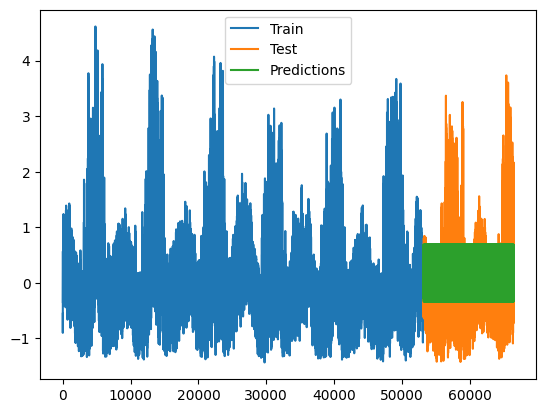

In [11]:
#plot the predictions as a continued line starting from the train data
plt.plot(train['COMED_MW_scaled'], label='Train')
plt.plot(test['COMED_MW_scaled'], label='Test')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.show()

/tmp/ipykernel_7401/1049903803.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals, bins=30)


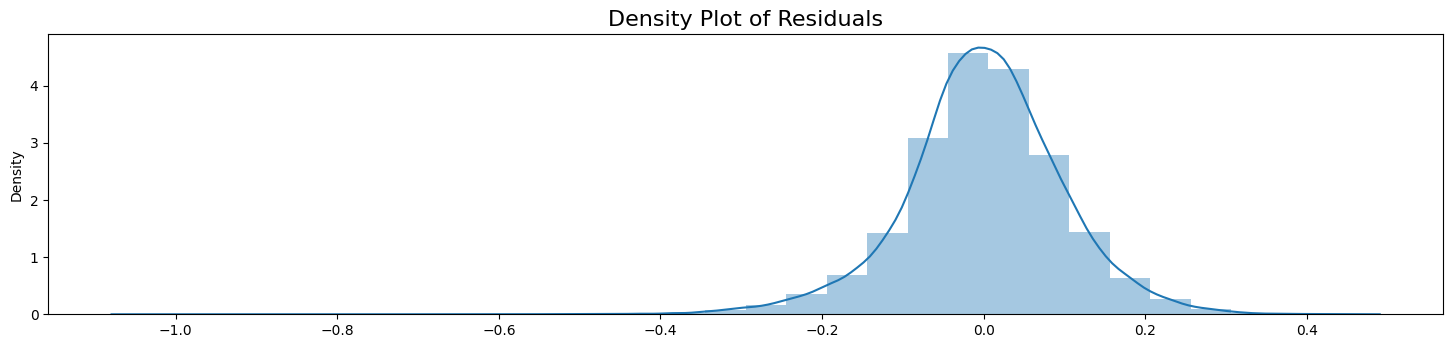

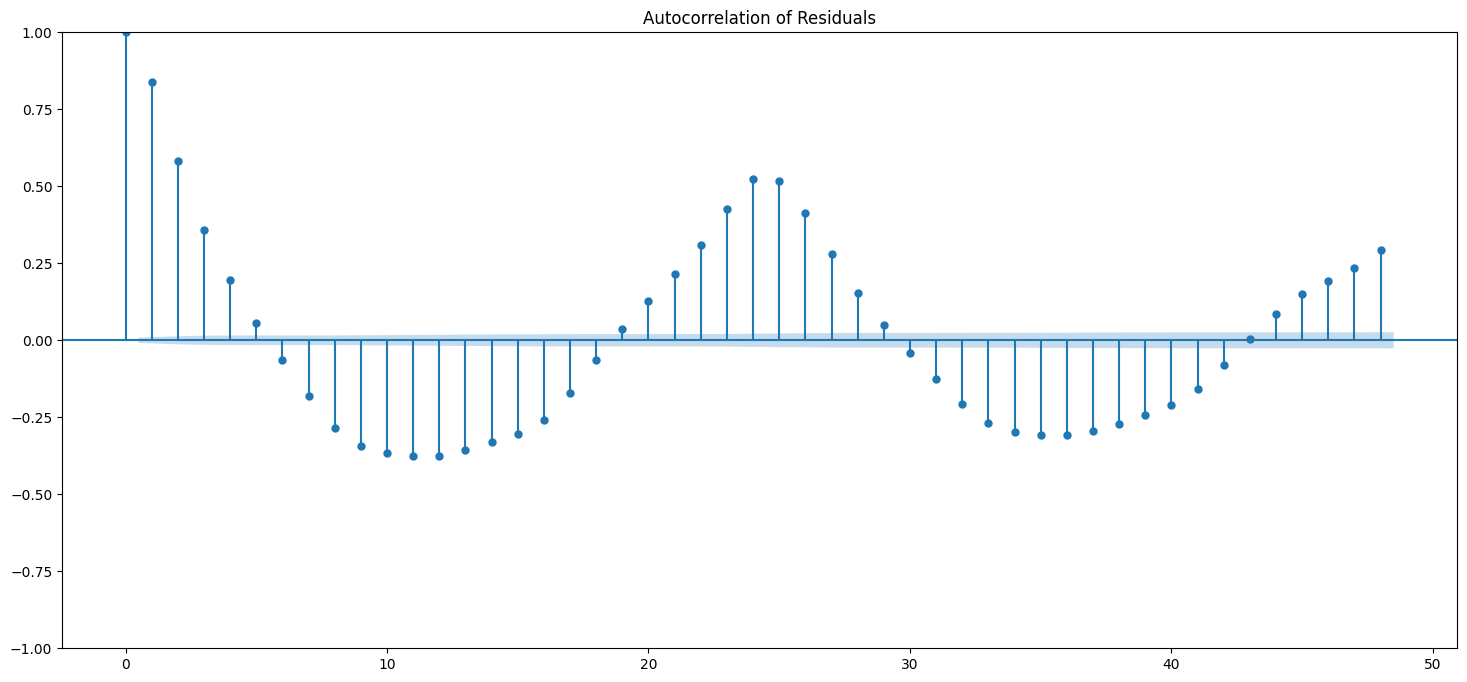

In [29]:
# Plot residuals
plt.figure(figsize=(18, 8))
# Density plot of residuals
plt.subplot(212)
sns.distplot(residuals, bins=30)
plt.title('Density Plot of Residuals', fontsize=16)
plt.show()
# ACF plot of residuals
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(18, 8))
plot_acf(residuals, ax=plt.gca(), title='Autocorrelation of Residuals')
plt.show()

## What do the plots tell us?
### Density Plot of Residuals:
Ideally, we want the residuals to be normally distributed, which suggests that the model is well-fitted and captures most of the patterns in the data.
In our plot, the distribution appears fairly normal, though slightly skewed to the left. The peak is close to zero, which is good as it indicates that most residuals are small. However, the skewness might suggest that the model is systematically underestimating or overestimating in certain situations.

### Autocorrelation of Residuals:
Ideally, the autocorrelation of residuals should be close to zero for all lags, indicating that the residuals are white noise—this means that the model has successfully captured all the information in the data, leaving no pattern in the residuals.

In our autocorrelation plot, there are significant spikes at several lags, notably at lags 1, 2, and at around 12, 24, etc. This suggests a seasonal pattern or trend that the model has not captured. Such a pattern at lags like 12 and 24 can typically indicate annual seasonality that is not adequately modeled.

In [12]:
# Save a csv file with the results. The csv file should contain the folllwing columns: ,Datetime,COMED_MW_scaled,Season_encoded,Time_of_day_encoded,Holiday_encoded,Predictions. The predictions should start from the first row of the test data and continue to the end of the test data. The total number of rows should be equal to the length of the total data.
df['Predictions'] = model.forecast(steps=len(df))
df.to_csv('test.csv', index=False)
df

,Datetime,COMED_MW_scaled,Season_encoded,Time_of_day_encoded,Holiday_encoded,Predictions
0,2011-01-01 01:00:00,-0.557143,3,3,1,NaN
1,2011-01-01 02:00:00,-0.688278,3,3,1,NaN
2,2011-01-01 03:00:00,-0.784249,3,3,1,NaN
3,2011-01-01 04:00:00,-0.883150,3,3,1,NaN
4,2011-01-01 05:00:00,-0.900366,3,3,1,NaN
...,...,...,...,...,...,...
66492,2018-08-02 20:00:00,1.935897,2,1,1,0.654155
66493,2018-08-02 21:00:00,1.625641,2,1,1,0.673020
66494,2018-08-02 22:00:00,1.441026,2,3,1,0.662086
66495,2018-08-02 23:00:00,1.207326,2,3,1,0.629070


In [34]:
#save the model 
import pickle
filename = 'ETS_model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [13]:
#load the model
import pickle
loaded_model = pickle.load(open('/home/hashim/Assignments/Sem6/DataMining/DM_Proj/models/ETS_model.pkl', 'rb'))

In [6]:
# Fit the model to the data
fitted_model = loaded_model.fit()

# Make predictions
df['Predictions'] = fitted_model.predict(start=0, end=len(df)-1)

# Save the DataFrame to a CSV file
df.to_csv('ETS_predictions.csv')